For a give set of edges: 
- load edges file
- construct network
- do a bunch of excercises and calculations: 
    - cliques 



In [36]:
import pandas as pd
import networkx as nx
from networkx import centrality
from networkx.algorithms import clique
from networkx.algorithms import core
from networkx.algorithms import traversal
from networkx.algorithms import distance_measures
from networkx.algorithms import approximation
from networkx.algorithms import shortest_paths
from networkx.algorithms import bridges, has_bridges, local_bridges
from helpers import graph_search

In [37]:
filename = 'edges/exam_a1.txt'

In [38]:
df_edges = pd.read_csv(filename, sep=':', header=None, names=['from', 'to_list'])
df_edges['to_list_split'] = df_edges.to_list.str.strip().str.split(',')
df_edges = df_edges.explode('to_list_split')
df_edges['from'] = df_edges['from'].astype('str')
# keep hold of nodes with no edges 
add_nodes = df_edges['from'][df_edges.to_list_split.isna()]
# drop incomplete edges 
df_edges.drop(list(add_nodes.index), inplace=True)
# list(df_edges[['from','to_list_split']].itertuples(index=False))
# [tuple(e) for i,e in df_edges[['from','to_list_split']].iterrows()]
# list(zip(df_edges['from'], df_edges['to_list_split']))
edges = [tuple(e) for e in df_edges[['from','to_list_split']].to_records(index=False)]

In [39]:
set(df_edges['to_list_split'].astype(df_edges['from'].dtype))

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L'}

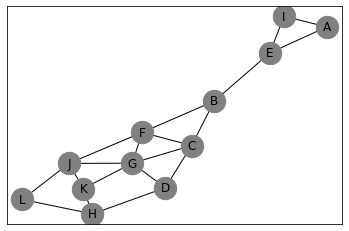

In [40]:
G = nx.Graph()
G.add_edges_from(edges)
G.add_nodes_from(add_nodes)

pos = nx.layout.spring_layout(G)
nx.draw_networkx(G, pos=pos, node_size=500, node_color='grey')

In [41]:
# print(nx.info(G))
network_properties = { 
    'nodes': G.order(), 
    'edges': G.size(),
    'average_degree': float(format(2 * G.size()/G.order(),'.3f')),
    'diameter': distance_measures.diameter(G), 
    'average_clustering_coefficient': approximation.average_clustering(G)
    }

for k,v in network_properties.items():
    print(k,v)

nodes 12
edges 19
average_degree 3.167
diameter 5
average_clustering_coefficient 0.444


In [42]:
def get_df(measure, column_name):
    return pd.DataFrame(dict(measure).items(), columns=['node', column_name])

def add_measure(df, measure,column_name): 
    temp = df.join(get_df(measure,column_name),lsuffix='',rsuffix='_r')
    return temp.drop(columns=temp.columns[temp.columns.str.endswith('_r')])

In [43]:
df_measures = pd.DataFrame(list(G.nodes()), columns=['node'])
df_measures

,node
0,A
1,E
2,I
3,B
4,C
5,F
6,D
7,G
8,H
9,K


# add measures 

* clustering coefficient 
* degree
* degree centrality 
* closenness cenrality 
* betweenness cenrality 

In [44]:
df_measures = add_measure(df_measures, nx.clustering(G), 'clustring')
df_measures = add_measure(df_measures, nx.degree(G), 'degree')
df_measures = add_measure(df_measures, centrality.degree_centrality(G), 'degree_centrality')
df_measures = add_measure(df_measures, centrality.closeness_centrality(G), 'closeness_centrality')
df_measures['closeness_inv'] = 1/df_measures['closeness_centrality']
df_measures = add_measure(df_measures, centrality.betweenness_centrality(G, normalized=False), 'betweenness')
df_measures = add_measure(df_measures, centrality.betweenness_centrality(G, normalized=True), 'betweenness_centrality')
df_measures = add_measure(df_measures, core.core_number(G), 'core')


In [45]:
add_measure(df_measures, centrality.closeness_centrality(G), 'closeness_centrality')

,node,clustring,degree,degree_centrality,closeness_centrality,closeness_inv,betweenness,betweenness_centrality,core
0,A,1.000000,2,0.181818,0.297297,3.363636,0.000000,0.000000,2
1,E,0.333333,3,0.272727,0.392857,2.545455,18.000000,0.327273,2
2,I,1.000000,2,0.181818,0.297297,3.363636,0.000000,0.000000,2
3,B,0.333333,3,0.272727,0.500000,2.000000,24.000000,0.436364,2
4,C,0.500000,4,0.363636,0.523810,1.909091,12.033333,0.218788,2
5,F,0.500000,4,0.363636,0.523810,1.909091,13.500000,0.245455,2
6,D,0.333333,3,0.272727,0.458333,2.181818,6.233333,0.113333,2
7,G,0.400000,5,0.454545,0.500000,2.000000,7.400000,0.134545,2
8,H,0.000000,3,0.272727,0.379310,2.636364,2.333333,0.042424,2
9,K,0.333333,3,0.272727,0.392857,2.545455,1.400000,0.025455,2


The core number of a node is the largest value k of a k-core containing that node.

# find all cliques and maximal cliques 

In [46]:

maximal_cliques = [''.join(sorted(c)) for c in clique.find_cliques(G)]
print('maximal cliques')
print(maximal_cliques)

maximal cliques
['CDG', 'FGJ', 'CFG', 'GJK', 'AEI', 'HL', 'JL', 'DH', 'HK', 'BE', 'BCF']


In [47]:
df_cliques = pd.DataFrame([(len(c), sorted(c), ''.join(sorted(c))) for c in clique.enumerate_all_cliques(G) if len(c) > 2], columns=['clique_size', 'clique_list', 'clique'])
df_cliques['maximal_clique'] = df_cliques.clique.isin(maximal_cliques)
df_cliques.query( "maximal_clique == True")

,clique_size,clique_list,clique,maximal_clique
0,3,"[A, E, I]",AEI,True
1,3,"[B, C, F]",BCF,True
2,3,"[C, F, G]",CFG,True
3,3,"[C, D, G]",CDG,True
4,3,"[F, G, J]",FGJ,True
5,3,"[G, J, K]",GJK,True


In [48]:
df_cliques.query('clique_size == 3')

,clique_size,clique_list,clique,maximal_clique
0,3,"[A, E, I]",AEI,True
1,3,"[B, C, F]",BCF,True
2,3,"[C, F, G]",CFG,True
3,3,"[C, D, G]",CDG,True
4,3,"[F, G, J]",FGJ,True
5,3,"[G, J, K]",GJK,True


# k-core

In [49]:
print('maximal k-core with k = ', max(df_measures.core), ': ', ''.join(sorted([k for k in core.k_core(G)])))

maximal k-core with k =  2 :  ABCDEFGHIJKL


In [50]:
k = 2
''.join(sorted(df_measures.query(f'core >= {k}')['node']))

'ABCDEFGHIJKL'

In [51]:
[c for c in nx.isolates(G)]

[]

# network traversal: BFS and DFS

In [52]:
start_node = 'A'

In [53]:
print(f'BFS traversal start at {start_node}: ', ' '.join([b for b in traversal.bfs_tree(G, start_node)]))

BFS traversal start at A:  A E I B C F D G J H K L


In [54]:
print(f'DFS traversal start at {start_node}: ', ' '.join([b for b in traversal.dfs_tree(G, start_node)]))

DFS traversal start at A:  A E I B C D G J L H K F


Edge Betweenness 

In [55]:
[e for e in traversal.edge_bfs(G, 'A')]

[('A', 'E'),
 ('A', 'I'),
 ('E', 'I'),
 ('E', 'B'),
 ('B', 'C'),
 ('B', 'F'),
 ('C', 'D'),
 ('C', 'F'),
 ('C', 'G'),
 ('F', 'J'),
 ('F', 'G'),
 ('D', 'G'),
 ('D', 'H'),
 ('G', 'J'),
 ('G', 'K'),
 ('J', 'L'),
 ('J', 'K'),
 ('H', 'K'),
 ('H', 'L')]

# shortest paths

In [56]:
nodes_list = list(G.nodes)

diameter = 0
diameter_path = None
all_shortest_paths = []
for i, start_n in enumerate(G.nodes): 
    print(i, start_n)
    nodes_list.pop(0) # remove current node from nodes list
    str = ""

    diameter_updated = False
    for j, target_n in enumerate(nodes_list):
        # shortest_path = nx.dijkstra_path(G, source=start_n, target=target_n)
        shortest_path = shortest_paths.all_shortest_paths(G, source=start_n, target=target_n)
        shortest_path = [''.join(sp) for sp in shortest_path]
        shortest_path_length = nx.dijkstra_path_length(G, source=start_n, target=target_n)
        # str = str + f"({j}, {target_n}, {'-'.join(shortest_path)}, {shortest_path_length})"
        all_shortest_paths.append((start_n, target_n, shortest_path, shortest_path_length, len(shortest_path)))
        if shortest_path_length > diameter:
            diameter = shortest_path_length
            diameter_path = shortest_path
            diameter_updated = True
    # print(str)
    print(f"{'update diameter' if diameter_updated else ''}")

shortest_paths_df = pd.DataFrame(all_shortest_paths, columns=['from', 'to', 'geodesic', 'length', 'count'])

0 A
update diameter
1 E

2 I

3 B

4 C

5 F

6 D

7 G

8 H

9 K

10 L

11 J



## potential local bridges

In [81]:
print('potential local bridges, if span > 2')
shortest_paths_df.query('to == "H"')

potential local bridges, if span > 2


,from,to,geodesic,length,count
7,A,H,[AEBCDH],5,1
17,E,H,[EBCDH],4,1
26,I,H,[IEBCDH],5,1
34,B,H,[BCDH],3,1
41,C,H,[CDH],2,1
47,F,H,"[FCDH, FGDH, FJLH, FJKH, FGKH]",3,5
52,D,H,[DH],1,1
56,G,H,"[GDH, GKH]",2,2


In [82]:
shortest_paths_df.query('length == 5')

,from,to,geodesic,length,count
7,A,H,[AEBCDH],5,1
8,A,K,"[AEBCGK, AEBFGK, AEBFJK]",5,3
9,A,L,[AEBFJL],5,1
26,I,H,[IEBCDH],5,1
27,I,K,"[IEBCGK, IEBFGK, IEBFJK]",5,3
28,I,L,[IEBFJL],5,1


In [58]:
has_bridges(G)

True

In [59]:
# G_bridges = [b for b in bridges(G)]
df_local_bridges = pd.DataFrame([b for b in local_bridges(G)], columns=['from', 'to', 'span'])

## detecting bridges and local bridges 

definitins: 
* a-b is bridge -> graph disconnects if a-b is removed 
* a-b is local bridge -> there is another path between a-b with span > 2 and not other common connected nodes. 

`local_bridges()`: 

A local bridge is an edge whose endpoints have no common neighbors. That is, the edge is not part of a triangle in the graph.
The span of a local bridge is the shortest path length between the endpoints if the local bridge is removed.

in result of `local_bridges()`, if `span is inf`, then this global bridge, that is graph will disconnect if edge removed. 

In [60]:
print('local bridges, alternate span inf > means a bridge, will disconnect network if removed ')
print(df_local_bridges)

local bridges, alternate span inf > means a bridge, will disconnect network if removed 
  from to  span
0    E  B   inf
1    D  H   3.0
2    H  K   3.0
3    H  L   3.0
4    L  J   3.0


# Isomorphism 

In [61]:
g2_filename = 'edges\isomorphism_g2.txt'
df_edges2 = pd.read_csv(g2_filename, sep=':', header=None, names=['from', 'to_list'])
df_edges2['to_list_split'] = df_edges2.to_list.str.strip().str.split(',')
df_edges2 = df_edges2.explode('to_list_split')
df_edges2['from'] = df_edges2['from'].astype('str')
add_nodes2 = df_edges2['from'][df_edges2.to_list_split.isna()]
df_edges2.drop(list(add_nodes2.index), inplace=True)
edges2 = [tuple(e) for e in df_edges2[['from','to_list_split']].to_records(index=False)]
G2 = nx.Graph()
G2.add_edges_from(edges2)
G2.add_nodes_from(add_nodes2)

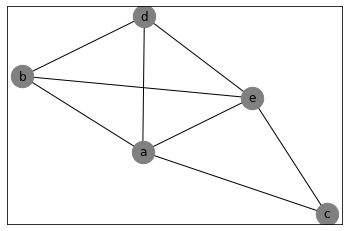

In [62]:

pos2 = nx.layout.spring_layout(G2)
nx.draw_networkx(G2, pos=pos2, node_size=500, node_color='grey')

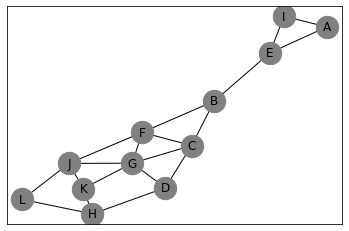

In [63]:
nx.draw_networkx(G, pos=pos, node_size=500, node_color='grey')

In [64]:
from networkx.algorithms import isomorphism

print('could be isomorphic: ', isomorphism.could_be_isomorphic(G,G2))

could be isomorphic:  False


In [65]:
GM = isomorphism.GraphMatcher(G, G2)
GM.is_isomorphic()

False

In [66]:
pd.DataFrame(GM.mapping.items(), columns={'G', 'G1'}).sort_values(by='G')

,G,G1


In [67]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 12
Number of edges: 19
Average degree:   3.1667


In [68]:
print(nx.info(G2))

Name: 
Type: Graph
Number of nodes: 5
Number of edges: 8
Average degree:   3.2000


In [69]:
[e for e in G.edges()]

[('A', 'E'),
 ('A', 'I'),
 ('E', 'I'),
 ('E', 'B'),
 ('B', 'C'),
 ('B', 'F'),
 ('C', 'D'),
 ('C', 'F'),
 ('C', 'G'),
 ('F', 'J'),
 ('F', 'G'),
 ('D', 'G'),
 ('D', 'H'),
 ('G', 'J'),
 ('G', 'K'),
 ('H', 'K'),
 ('H', 'L'),
 ('K', 'J'),
 ('L', 'J')]

In [70]:
[e for e in G2.edges()]

[('a', 'b'),
 ('a', 'e'),
 ('a', 'd'),
 ('a', 'c'),
 ('b', 'd'),
 ('b', 'e'),
 ('e', 'c'),
 ('e', 'd')]